# 0. Import

In [1]:
!pip -q install pixellib --upgrade
!pip show pixellib

Name: pixellib
Version: 0.7.1
Summary: PixelLib is a library used for easy implementation of semantic and instance segmentation of objects in images and videos with few lines of code.PixelLib makes it possible to train a custom segmentation model using few lines of code.PixelLib supports background editing of images and videos using few lines of code.
Home-page: https://github.com/ayoolaolafenwa/PixelLib
Author: Ayoola Olafenwa
Author-email: UNKNOWN
License: MIT
Location: /opt/conda/lib/python3.9/site-packages
Requires: black, cloudpickle, Cython, dataclasses, future, fvcore, hydra-core, imantics, imgaug, iopath, labelme2coco, matplotlib, omegaconf, opencv-python, pillow, pydot, pyQt5, scikit-image, tabulate, termcolor, tqdm, yacs
Required-by: 


In [2]:
import os
import urllib
import cv2
import numpy as np
from importlib.metadata import version
import fileinput
import pixellib
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
import warnings 
# warning 무시
warnings.filterwarnings("ignore")

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


# 1. Load Model, Images

In [3]:
# Path 설정
BASE_PATH = '/workspace/userdisk/human_segmentation/'
DATA_PATH = os.path.join(BASE_PATH,'images')
MODEL_PATH = os.path.join(BASE_PATH,'models')

In [4]:
# Load Images
images_name =[
    '아스트로.jpeg', # 사람 여러명
    '누워있는_차은우.jpeg',
    '앉은_차은우.jpeg',
    '부채_차은우.jpeg',
    '엎드린_차은우.jpg',
    '야잠_차은우.jpg',
]

image_dict = {} # name을 키로
for name in images_name:
    img_path = os.path.join(DATA_PATH, name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.IMREAD_COLOR)  # OpenCV는 BGR로 로드되므로 RGB로 변환
        image_dict[name] = img
        print(f"이미지 로드 완료: {name}")
    else:
        print(f"이미지를 불러올 수 없습니다: {img_path}")

이미지 로드 완료: 아스트로.jpeg
이미지 로드 완료: 누워있는_차은우.jpeg
이미지 로드 완료: 앉은_차은우.jpeg
이미지 로드 완료: 부채_차은우.jpeg
이미지 로드 완료: 엎드린_차은우.jpg
이미지 로드 완료: 야잠_차은우.jpg


In [5]:
# 모델 다운로드
model_file = os.path.join(MODEL_PATH, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)

# 모델 로드
model = semantic_segmentation() # semantic segmentation 클래스 인스턴스
model.load_pascalvoc_model(model_file) # pascal voc 훈련 모델

# 2. Segmentation

In [6]:
# 라벨 이름
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 컬러맵 생성
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [7]:
#이미지 분할

from ast import Continue
results = {}

for name in images_name:
    img_path = os.path.join(DATA_PATH, name) #이미지 path
    segvalues, output = model.segmentAsPascalvoc(img_path) # segmentation
    
    if segvalues is None:
        print(f"이미지 분할 실패: {name}")
        continue
    print(f"이미지 분할 성공: {name}")
    results[name] = {
            "image": image_dict.get(name), 
            "segvalues": segvalues,
            "output": output
        }

print(f"총 분할 완료 이미지 수: {len(results)}개")

이미지 분할 성공: 아스트로.jpeg
이미지 분할 성공: 누워있는_차은우.jpeg
이미지 분할 성공: 앉은_차은우.jpeg
이미지 분할 성공: 부채_차은우.jpeg
이미지 분할 성공: 엎드린_차은우.jpg
이미지 분할 성공: 야잠_차은우.jpg
총 분할 완료 이미지 수: 6개


세그맨테이션 결과 plot 함수 

In [8]:
def visualize_segmentation(images_name, segmentation_result, label_names, color_map,figsize=(15, 6)):
    # color map은 rgb 순서고, output은 bgr순서이므로 colormap의 순서 바꿔야 함
    bgr_colormap = color_map[:, ::-1] #RGB -> BGR

    for name in images_name:
        data = segmentation_result.get(name)
        print(f"{name}의 segmentation 결과")
        if data is None:
            print(f"    [X] {name}에 대한 segmentation 결과가 없습니다.")
            continue
            
        image = data["image"] #BGR
        segmap = data["segvalues"]["masks"] # True, False
        class_ids = data["segvalues"]["class_ids"] 
        output_bgr = data["output"]# PixelLib output (BGR)

        # 검출된 클래스 이름들 출력
        detected_classes=[label_names[class_id] for class_id in class_ids]
        print(f"    [1] 검출된 클래스: {detected_classes}")
        
        # 시각화
        plt.figure(figsize=figsize)

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB))
        plt.title("PixelLib Output")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

아스트로.jpeg의 segmentation 결과
    [1] 검출된 클래스: ['background', 'car', 'person']


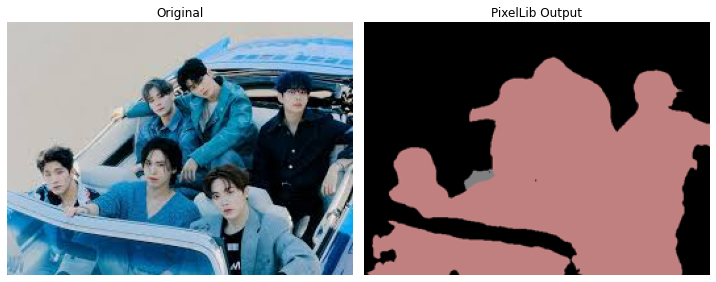

누워있는_차은우.jpeg의 segmentation 결과
    [1] 검출된 클래스: ['background', 'bottle', 'diningtable', 'person', 'pottedplant', 'sofa']


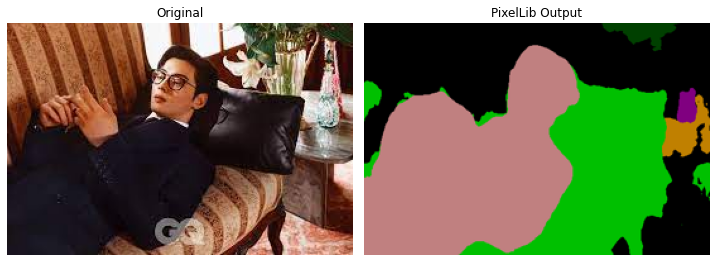

앉은_차은우.jpeg의 segmentation 결과
    [1] 검출된 클래스: ['background', 'chair', 'person', 'pottedplant']


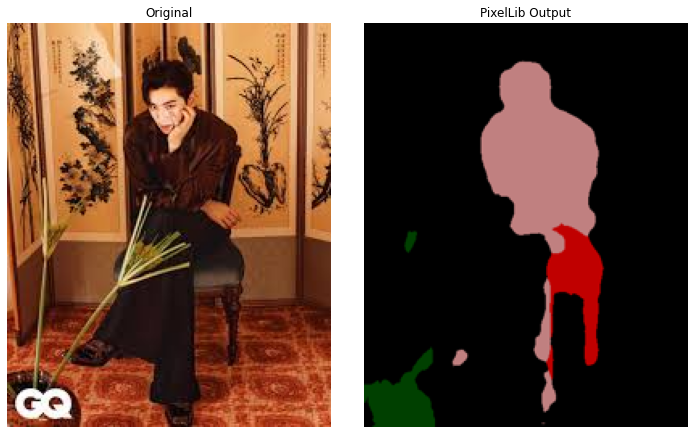

부채_차은우.jpeg의 segmentation 결과
    [1] 검출된 클래스: ['background', 'person', 'pottedplant']


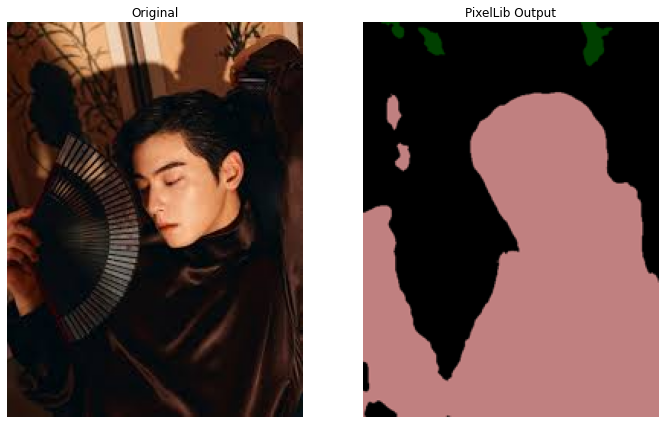

엎드린_차은우.jpg의 segmentation 결과
    [1] 검출된 클래스: ['background', 'person', 'sofa']


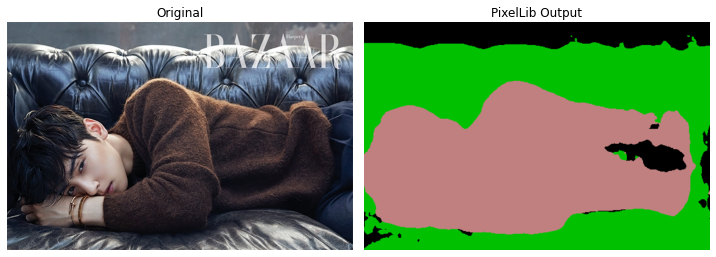

야잠_차은우.jpg의 segmentation 결과
    [1] 검출된 클래스: ['background', 'diningtable', 'person']


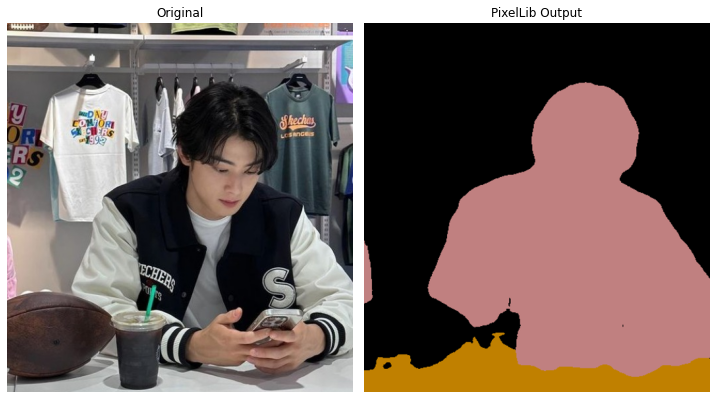

In [9]:
visualize_segmentation(
    images_name=results.keys(),
    segmentation_result=results,
    label_names=LABEL_NAMES,
    color_map=colormap
)

 - 첫번째 아스트로 자동차 사진
     - 자동차가 꽤 많은 면적을 차지하고 있는데 매우 일부분만 올바르게 분할하고, 나머지 부분은 사람과 배경으로 분할됨
 - 두번째 차은우 누워있는사진
     - 사람을 어느정도 잘 구분했지만, 복잡한 뒷부분은 제대로 분할하지 못하고 있다.
     - 소파 아닌부분도 소파로 분류한 것이 보임, 소파인데 배경으로 분류한 것도 보인다.
 - 세번째 식물에 가린 앉은 차은우 사진
     - 차은우의 상반신은 잘 분할했으나 식물에 가려진부분부터는 잘 분할하지 못함
     - 심지어 pottedplant도 잘 분할하지 못했음
 - 부채 든 차은우 사진
     - 사람을 잘 분할했다.(그러나 병풍의 일부분 중 빛이 들어오는 부분이 사람으로 분할됨)
     - 병풍의 그림을 ppotted plant로 분할한 것이 보인다.
 - 엎드린 차은우
     - 소파를 잘 분할 함. 
     - 차은우의 상반신도 잘 분할함
     - 그러나 소파와 차은우의 하의 색이 비슷해서인지 소파로 분할됨
 - 야잠 차은우
     - 잘 분할했다.아마 앞에 가리는 것이 많지 않아서 그런 듯 하다
     
대체로 물체가 평면상에 놓여있다면 잘 분할하는것으로 보인다.
그러나 색이 비슷하거나, 물체간으 거리가 달라 일부분이 가리는 경우 잘 분할하지 못하는 것 같다.

# 3. Shallow Focusing

In [10]:
# shallow_objects 로 선명하게 남길 부분 넘겨준다.
def shallowfocusing(images_name, segmentation_result, label_names, shallow_objects, color_map,figsize=(15, 6)):
    
    bgr_colormap = color_map[:, ::-1] #RGB -> BGR
    
    for name in images_name:
        data = segmentation_result.get(name)
        print(f"{name}의 shallow focusing 결과")
        if data is None:
            print(f"❌ {name}에 대한 segmentation 결과가 없습니다.")
            continue

        image = data["image"]  # BGR
        masks = data["segvalues"]["masks"]  # (num_classes, H, W), Boolean data
        class_ids = data["segvalues"]["class_ids"] 
        output_bgr = data["output"]# # PixelLib output (BGR)
        
        # 사진에서 검출된 클래스 출력
        detected_classes=[label_names[class_id] for class_id in class_ids]
        print(f"    [1] 검출된 클래스: {detected_classes}")

        # 어떤 class를 선명하게 할지 출력 (선택된 class 인덱스 추출)
        shallow_class_ids = [class_id for class_id in class_ids if label_names[class_id] in shallow_objects]
        print(f'    [2] shallow_objects에 해당하는 클래스 인덱스: {shallow_class_ids}')
    
        if not shallow_class_ids:
            print(f"⚠️ {name}: shallow_objects에 해당하는 클래스 없음, 전체 블러됨")
        else:
            print(f"✅ {name}: 초점 처리할 클래스 → {[label_names[i] for i in shallow_class_ids]}")

        # 블러 처리, 가우시안필터사용, 시그마는 5
        blurred = cv2.GaussianBlur(image, (0, 0), 5)

        # 마스크 생성 (bool 연산)
        # 이미지랑 같은 크기의 False 넘파이배열 만듬
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=bool)
        
        # shallow_class_ids에 해당하는 클래스의 색상(BGR)만 추출
        for class_id in shallow_class_ids:
            class_color_bgr = tuple(bgr_colormap[class_id])  # (B, G, R) 형태

            # output_bgr에서 해당 색상과 정확히 일치하는 픽셀만 True
            match = np.all(output_bgr == class_color_bgr, axis=-1) 

            # 누적
            mask |= match
            
        mask = mask.astype(np.uint8)
        mask = np.stack([mask]*3, axis=-1)

        # 초점 이미지 생성
        focused = np.where(mask == 1, image, blurred)

        # 시각화
        plt.figure(figsize=figsize)
        plt.imshow(cv2.cvtColor(focused, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

아스트로.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'car', 'person']
    [2] shallow_objects에 해당하는 클래스 인덱스: [7, 15]
✅ 아스트로.jpeg: 초점 처리할 클래스 → ['car', 'person']


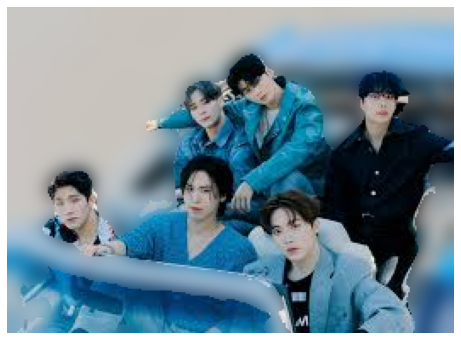

누워있는_차은우.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'bottle', 'diningtable', 'person', 'pottedplant', 'sofa']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15]
✅ 누워있는_차은우.jpeg: 초점 처리할 클래스 → ['person']


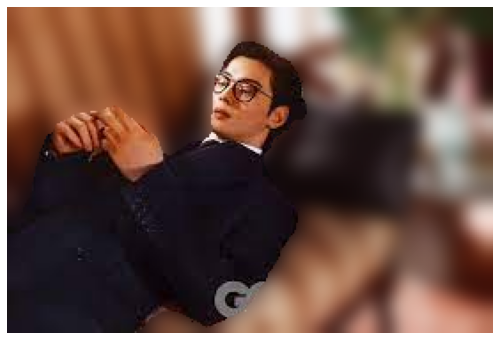

앉은_차은우.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'chair', 'person', 'pottedplant']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15]
✅ 앉은_차은우.jpeg: 초점 처리할 클래스 → ['person']


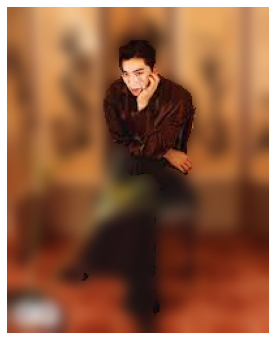

부채_차은우.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'person', 'pottedplant']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15]
✅ 부채_차은우.jpeg: 초점 처리할 클래스 → ['person']


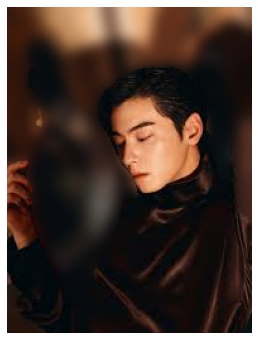

엎드린_차은우.jpg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'person', 'sofa']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15]
✅ 엎드린_차은우.jpg: 초점 처리할 클래스 → ['person']


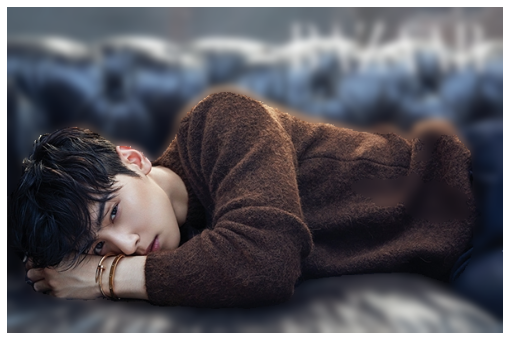

야잠_차은우.jpg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'diningtable', 'person']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15]
✅ 야잠_차은우.jpg: 초점 처리할 클래스 → ['person']


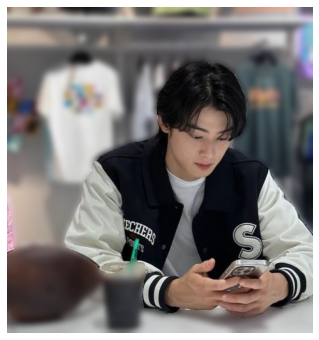

In [11]:
# 사람과 차를 남기고 블러
shallowfocusing(
    images_name=results.keys(),
    segmentation_result=results,
    label_names=LABEL_NAMES,
    shallow_objects=["person", "car"],
    color_map=colormap
)

아스트로.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'car', 'person']
    [2] shallow_objects에 해당하는 클래스 인덱스: [0]
✅ 아스트로.jpeg: 초점 처리할 클래스 → ['background']


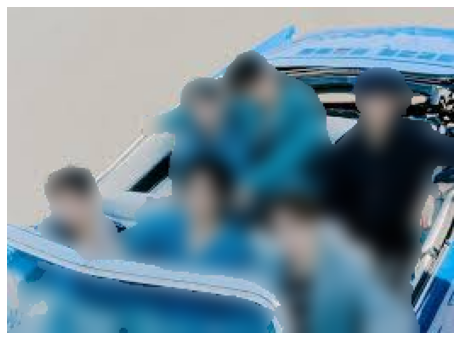

누워있는_차은우.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'bottle', 'diningtable', 'person', 'pottedplant', 'sofa']
    [2] shallow_objects에 해당하는 클래스 인덱스: [0, 18]
✅ 누워있는_차은우.jpeg: 초점 처리할 클래스 → ['background', 'sofa']


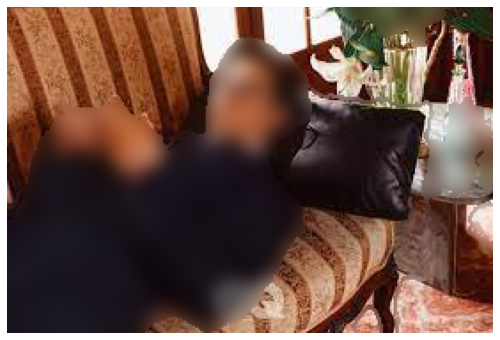

앉은_차은우.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'chair', 'person', 'pottedplant']
    [2] shallow_objects에 해당하는 클래스 인덱스: [0]
✅ 앉은_차은우.jpeg: 초점 처리할 클래스 → ['background']


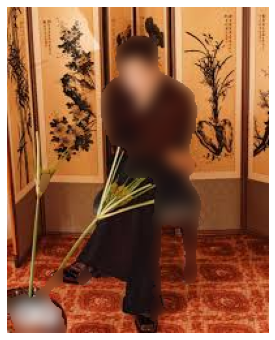

부채_차은우.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'person', 'pottedplant']
    [2] shallow_objects에 해당하는 클래스 인덱스: [0]
✅ 부채_차은우.jpeg: 초점 처리할 클래스 → ['background']


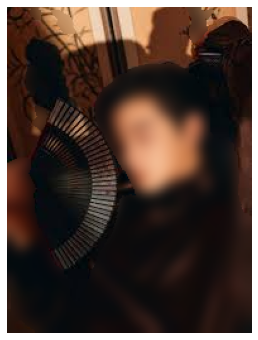

엎드린_차은우.jpg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'person', 'sofa']
    [2] shallow_objects에 해당하는 클래스 인덱스: [0, 18]
✅ 엎드린_차은우.jpg: 초점 처리할 클래스 → ['background', 'sofa']


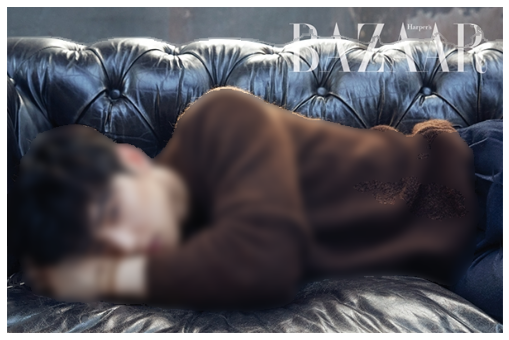

야잠_차은우.jpg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'diningtable', 'person']
    [2] shallow_objects에 해당하는 클래스 인덱스: [0]
✅ 야잠_차은우.jpg: 초점 처리할 클래스 → ['background']


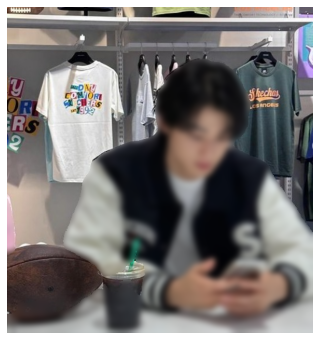

In [12]:
# 배경과 소파를 남기고 블러
shallowfocusing(
    images_name=results.keys(),
    segmentation_result=results,
    label_names=LABEL_NAMES,
    shallow_objects=["background", "sofa"],
    color_map=colormap
)

- 필터링 시에 시그마를 크게하는 편이 눈에 띄기 때문에 5로 설정했다.
- shallow_objects 에 리스트로 선명하게 둘 object name을 넘겨주면, 나머지를 블러 처리하고, 해당 클래스의 segment만 선명하게 남겼다.
- 기존 segmentation 결과대로 잘 적용되었다.

# 4. Chromakey

In [13]:
# 크로마키를 함수 선언

def chromakey(chromakey_img,images_name, segmentation_result, label_names, shallow_objects, color_map,figsize=(15, 6)):
    
    bgr_colormap = color_map[:, ::-1] #RGB -> BGR
    
    for name in images_name:
        data = segmentation_result.get(name)
        print(f"{name}의 shallow focusing 결과")
        if data is None:
            print(f"❌ {name}에 대한 segmentation 결과가 없습니다.")
            continue
        
        # 기존 이미지
        image = data["image"]  # BGR
        masks = data["segvalues"]["masks"]  # (num_classes, H, W), Boolean data
        class_ids = data["segvalues"]["class_ids"] 
        output_bgr = data["output"]# # PixelLib output (BGR)
        
        # 사진에서 검출된 클래스 출력
        detected_classes=[label_names[class_id] for class_id in class_ids]
        print(f"    [1] 검출된 클래스: {detected_classes}")

        # 어떤 class를 선명하게 할지 출력 (선택된 class 인덱스 추출)
        shallow_class_ids = [class_id for class_id in class_ids if label_names[class_id] in shallow_objects]
        print(f'    [2] shallow_objects에 해당하는 클래스 인덱스: {shallow_class_ids}')
    
        if not shallow_class_ids:
            print(f"⚠️ {name}: shallow_objects에 해당하는 클래스 없음, 전체 블러됨")
        else:
            print(f"✅ {name}: 초점 처리할 클래스 → {[label_names[i] for i in shallow_class_ids]}")

        # 블러 처리, 가우시안필터사용, 시그마는 5, 커널크기 자동
        blurred = cv2.GaussianBlur(image, (0, 0), 5)

        # 마스크 생성 (bool 연산)
        # 이미지랑 같은 크기의 False 넘파이배열 만듬
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=bool)
        
        # shallow_class_ids에 해당하는 클래스의 색상(BGR)만 추출
        for class_id in shallow_class_ids:
            class_color_bgr = tuple(bgr_colormap[class_id])  # (B, G, R) 형태

            # output_bgr에서 해당 색상과 정확히 일치하는 픽셀만 True
            match = np.all(output_bgr == class_color_bgr, axis=-1) 

            # 누적
            mask |= match
            
        mask = mask.astype(np.uint8)
        mask = np.stack([mask]*3, axis=-1)
        
        # 크로마키로 넣을 이미지 리사이즈
        chromakey_resized = cv2.resize(chromakey_img, (image.shape[1], image.shape[0]))

        # 크로마키 완료이미지 생성
        focused = np.where(mask == 1, image, chromakey_resized)

        # 시각화
        plt.figure(figsize=figsize)
        plt.imshow(cv2.cvtColor(focused, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

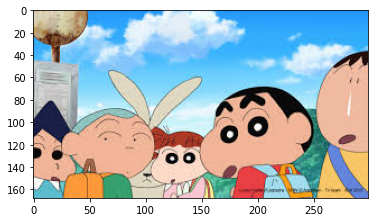

In [14]:
# 크로마키 이미지 
img_path = os.path.join(DATA_PATH, '짱구.jpeg')
shinchan = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(shinchan, cv2.COLOR_BGR2RGB))

아스트로.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'car', 'person']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15]
✅ 아스트로.jpeg: 초점 처리할 클래스 → ['person']


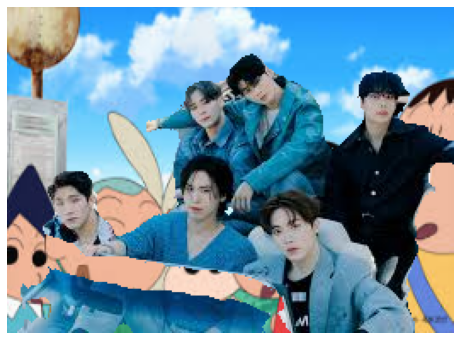

누워있는_차은우.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'bottle', 'diningtable', 'person', 'pottedplant', 'sofa']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15, 18]
✅ 누워있는_차은우.jpeg: 초점 처리할 클래스 → ['person', 'sofa']


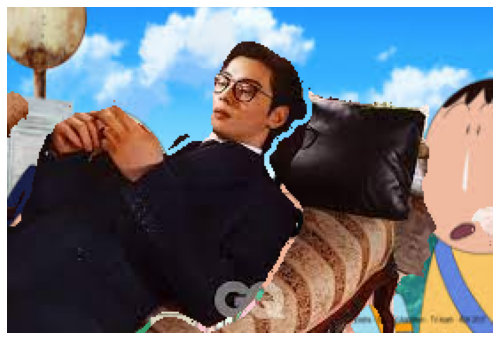

앉은_차은우.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'chair', 'person', 'pottedplant']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15]
✅ 앉은_차은우.jpeg: 초점 처리할 클래스 → ['person']


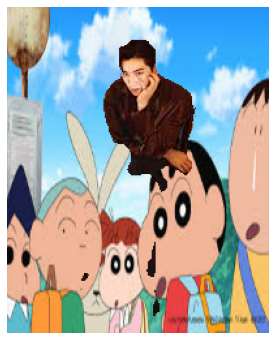

부채_차은우.jpeg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'person', 'pottedplant']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15]
✅ 부채_차은우.jpeg: 초점 처리할 클래스 → ['person']


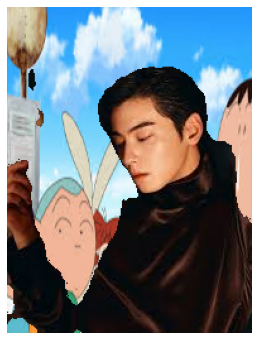

엎드린_차은우.jpg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'person', 'sofa']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15, 18]
✅ 엎드린_차은우.jpg: 초점 처리할 클래스 → ['person', 'sofa']


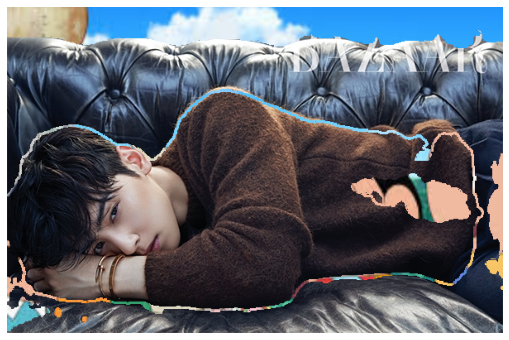

야잠_차은우.jpg의 shallow focusing 결과
    [1] 검출된 클래스: ['background', 'diningtable', 'person']
    [2] shallow_objects에 해당하는 클래스 인덱스: [15]
✅ 야잠_차은우.jpg: 초점 처리할 클래스 → ['person']


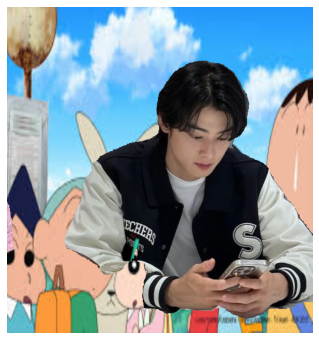

In [15]:
# 사람과 소파를 남기고 크로마키
chromakey(
    shinchan,
    images_name=results.keys(),
    segmentation_result=results,
    label_names=LABEL_NAMES,
    shallow_objects=["person", "sofa"],
    color_map=colormap
)

# 5. 사진 문제점 찾기

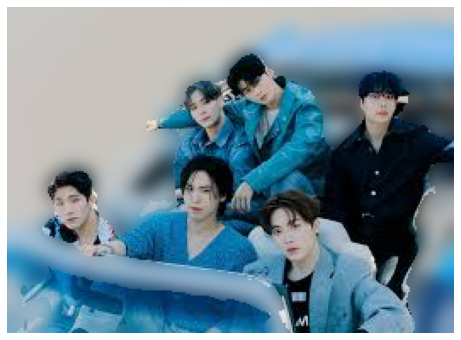

- 사람과 차를 남기고 shallow focusing 하려 함
- 근데 차가 백그라운드로 분할됨!
- 

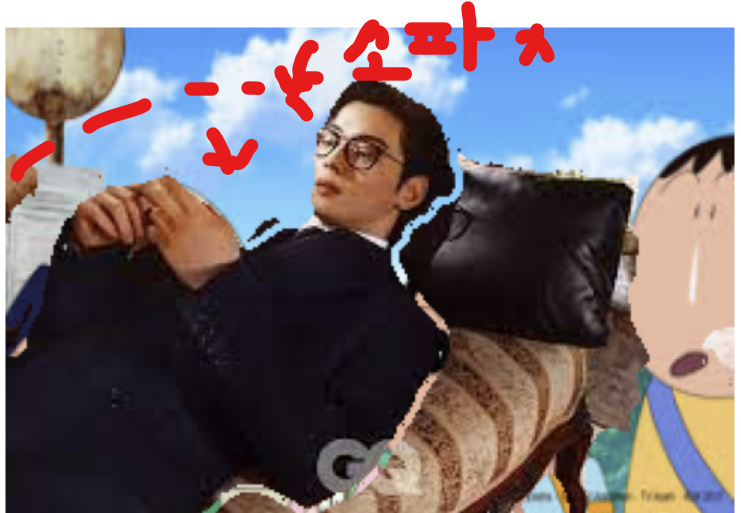
- 사람과 소파를 남기고 크로마키 적용
- 소파의 윗부분이 사라졌다
- 소파와 사람 사이의 경계선이 매우 부자연스러움

기본적으로 segmentation 결과에 따라서 사진이 shallow focusing/chromakey 되므로, 더 나은 segmentation을 할 수 있도록 해야 할 듯 하다

# 6. 해결방법

제시된 과제는 이미 촬영이 완료된 이미지에서 segmentation을 활용하여 outfocusing을 하는 것이었다.따라서 이미지의 촬영 시에 다른 각도의 이미지를 수집와 같은 방식을 사용한 해결은 불가능하다.

후처리에 기반을 둔 해결방식을 생각 할 수 있고, 또는 segmentation 방식을 바꾸는 방법이 있다.

해결책은 다음과 같이 두 가지 방향으로 나눌 수 있다:

1. 후처리 방식 개선

후처리 기반의 보정 방법으로 다음과 같은 접근이 가능하다.

- 경계선 부자연스러움 완화
        → Gaussian Blur의 커널 크기 및 시그마를 줄이면 경계선 부근의 흐려짐이 완만해져, 세분화된 영역 간의 경계 명료도를 높일 수 있다.

2. Segmentation 방식 변경

기존의 일반적인 Semantic Segmentation 방식은 2D 평면 정보만을 이용하므로, 사람과 배경 간 미묘한 깊이 차이나 경계선 처리에 한계가 있다.

- Depth Map 기반 Semantic Segmentation
        → 단일 RGB 이미지로부터 pseudo-depth map을 예측하거나, 별도의 depth 센서 기반 이미지가 존재하는 경우 이를 활용해 segmentation을 수행
    
- 3D 기반 세그멘테이션 모델 활용
        → 예: MiDaS, DPT (Dense Prediction Transformer), 또는 Self-Supervised Depth Estimation 기반 모델을 활용해 RGB로부터 깊이 추정 후 depth + RGB 정보를 함께 사용



# 회고

- 해결방법 고민 해보는 것이 재미있었다. 여유시간에 고안한 애결방법들이 어떻게 영향을 줄 지 직접 해보고싶다는 생각을 했다. 